<a href="https://colab.research.google.com/github/comp-neural-circuits/plasticity-workshop/blob/dev/hebbian_plasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm

In [ ]:
# utility functions

def setup_simulation(params):
    t = np.arange(0., params['t_sim'], params['dt'])
    rX = np.zeros((params['n0'], len(t)))
    rY = np.zeros((params['n1'], len(t)))
    wXY = np.zeros((params['n0']*params['n1'], len(t))) # later modify to store weights only sdt time steps
    return [t, rX, rY, wXY]

def show_rates(rX, rY, params, t1=0., t2=5000.):
    fig = plt.figure(figsize=[8,4])
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    id1, id2 = int(t1/params['dt']), int(t2/params['dt'])

    ax0 = fig.add_subplot(gs[0])
    im0 = ax0.imshow(rX[:,id1:id2], aspect='auto')
    ax0.set_title('Rate of Layer X')
    ax0.set_xlabel('Time (ms)')
    ax0.set_ylabel('Neuron id')
    plt.colorbar(im0, ax=ax0, label='Rate')

    ax1 = fig.add_subplot(gs[1])
    im1 = ax1.imshow(rY[:,id1:id2], aspect='auto')
    ax1.set_title('Rate of Layer Y')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Neuron id')
    plt.colorbar(im1, ax=ax1, label='Rate')

    fig.tight_layout()
    return

def show_weight_evolution(wXY, t, params):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(t, wXY.T, '-')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Synaptic weights')
    return

def show_weights_at_time(wXY, params, t3=0.):
    fig = plt.figure()
    ax = plt.gca()
    id3 = int(t3/params['dt'])
    idn = 0 # which postsynaptic neuron 
    ax.plot(np.arange(params['n0']), wXY[:,id3].reshape((params['n0'], params['n1']))[:,idn], '.-')
    ax.set_xlabel('Orientation')
    ax.set_ylabel('Weight')
    ax.set_ylim([params['w_low'], params['w_high']])
    return 

    

In [104]:
# plasticity functions

def update_weights_hebbian(w0, r0, r1, params):
    """
    r0 = rates of presynatic neurons   (n,1)
    r1 = rates of postsynaptic neurons (n,1)
    w0 = initial synaptic weights      (n,n)
    w1 = final synaptic weights        (n,n)
    """
    w1 = w0 + (params['dt']/params['tauw']) * np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0'])).reshape(-1)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

# there can also be hebbian with threshold (which then uses input covariance matrix instead of correlation matrix)

def update_weights_hebbian_subtractive_normalization(w0, r0, r1, params):
    Cw = np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0']))
    subtractive_part = np.sum(Cw)/np.size(Cw) 
    w1 = w0 + (params['dt']/params['tauw']) * (Cw.reshape(-1) - subtractive_part)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_hebbian_multiplicative_normalization(w0, r0, r1, params):
    w1 = w0 + (params['dt']/params['tauw']) * np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0'])).reshape(-1)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_BCM(w0):
    return w1

def rescale_weights(w, lower_bound, upper_bound):
    w[w < lower_bound] = lower_bound
    w[w > upper_bound] = upper_bound
    return w

In [ ]:
# input

def generate_regular_input_times(inter_event_interval, t_sim):
    return np.arange(0, t_sim, inter_event_interval)

# input: L-events

def generate_L_events_times(t_end, inter_event_interval):
    # generate sequence of L-event start times
    L_events_times = []
    _pt = 0. 
    while _pt < t_end:
        _pt += np.random.exponential(inter_event_interval)
        L_events_times.append(round(_pt, 1))
    return L_events_times

def define_L_event(n, amp_L, mean_dur, pct_low, pct_high):
    # for one L-event, specify the L-amp, L-neurons, L-dur
    amp = amp_L                                                             # amplitude
    dur = round(np.random.normal(mean_dur, mean_dur/10.), 1)                # duration
    pct = round(np.random.uniform(low=pct_low, high=pct_high), 2)           # participation ratio (20-60%)
    sN = np.random.choice(np.arange(n), 1)
    neur = np.roll(np.arange(n), -sN)[:int(pct*n)]                          # stimulated neurons
    return amp, dur, pct, neur

In [98]:
# Function to run 

def run_simulation(params, input_times):
    
    [t, rX, rY, wXY] = setup_simulation(params)
    
    # set initial weights
    wXY[:,0] = params['w_high']/2

    for _i, _t in enumerate(t):
        
        if _i == 0.:
          continue
        
        # state at time _t-1
        rx0, ry0 = rX[:,_i-1], rY[:,_i-1]
        wxy0 = wXY[:,_i-1]
        
        # specify input at this time and modify rx
        if _t in input_times:
          rx0[:] = 0.                           # remove the old input
          _n = np.random.choice(params['n0'])   # select which orientation input and/or neurons to activate
          rx0[_n] = params['input_amp']         # set the new input
        
        # update state to time _t
        rx1 = rx0
        ry1 = ry0 + (params['dt']/params['taum']) * (-ry0 + np.dot(rx0, wxy0.reshape(params['n0'], params['n1'])))
        #wxy1 = update_weights_hebbian(wxy0, rx1, ry1, params)
        wxy1 = update_weights_hebbian_subtractive_normalization(wxy0, rx1, ry1, params)

        # store
        rX[:,_i], rY[:,_i] = rx1, ry1
        wXY[:,_i] = wxy1
        
    return [t, rX, rY, wXY]

In [101]:
# define parameters

params = {
    'n0' : 10,              # number of presynaptic neurons
    'n1' : 1,              # number of postsynaptic neurons
    'taum' : 10.,           # tau for rate equation (ms)
    'tauw' : 10000.,       # tau for synaptic weight equation (ms)
    't_sim' : 200000.,        # Time of simulation (ms)    
    'dt' : 0.1,             # Time step for simulation
    'sdt' : 100.,           # Time step for storing/recording weights
    'input_iei' : 100.,     # inter event interval for input events
    'input_amp' : 1.,        # Amplitude of input to first layer
    'w_low' : 0.,
    'w_high' : 1.
}

Task: To form Receptive Fields or Orientation selective neurons

Input: We give regular input, and at every starting of input time point, we randomly select an orientation to activate. 


Plasticity rule: Hebbian 

In [102]:
# main

input_times = generate_regular_input_times(params['input_iei'], params['t_sim'])
[t, rX, rY, wXY] = run_simulation(params, input_times)

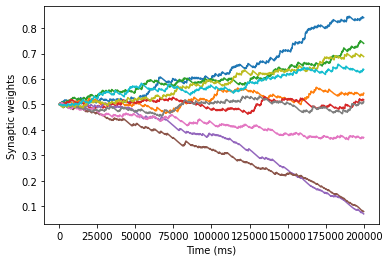

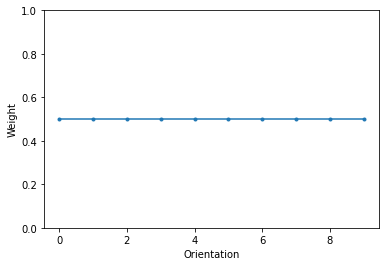

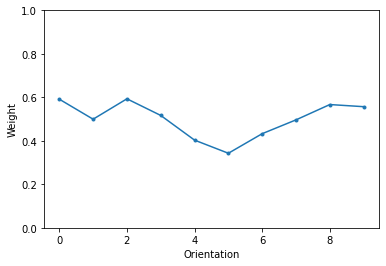

In [103]:
# visualize output

#show_rates(rX, rY, params, t1=0., t2=5000.)
show_weight_evolution(wXY, t, params)
show_weights_at_time(wXY, params, t3=0.)
show_weights_at_time(wXY, params, t3=80000.)